In [136]:
# packages
import gzip
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import json
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from collections import defaultdict
import time
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [3]:

review_filepath = "../assignment2/review-Idaho.json.gz"
meta_filepath = "../assignment2/meta-Idaho.json.gz"

reviews = []
bizs = []
for l in parse(review_filepath):
    reviews.append(l)

for l in parse(meta_filepath):
    bizs.append(l)

In [100]:
reviews_w_plus_minus_responses = [review for review in reviews if review.get("resp")]
print(len(reviews_w_plus_minus_responses))
reviews_with_responses = [review for review in reviews 
                          if ((review.get("resp")) and (review['resp']['time'] - review['time'] > 0))]
len(reviews_with_responses)

729928


700132

In [101]:
# Create new resp_time variable within each review
for r in reviews_with_responses:
    r['resp_time'] = r['resp']['time'] - r['time']

In [102]:
reviews_with_responses[0]

{'user_id': '115114032166130224762',
 'name': 'Mariah Schaeffer',
 'time': 1589989743506,
 'rating': 5,
 'text': 'Kevin and Shannon are amazing! They were very sweet and made the job fast! Also they are one of the cheeper junk removal services! I will for sure use again!',
 'pics': None,
 'resp': {'time': 1591139557205,
  'text': 'Thank you for hiring us for your junk removal!'},
 'gmap_id': '0x54afb4c19c4bffff:0x9389114191ca2781',
 'resp_time': 1149813699}

# Model #1 Baseline - Review Features

In [151]:
def baseline_feat(d):
    feat = [1]
    try:
        text_length = len(d['text'])
    except (KeyError, TypeError):
        text_length = 0 
    feat.append(text_length)
    feat.append(d.get('rating', 0))
    feat.append(d.get('time', 0))
    return feat

In [ ]:
def binarizeWeekResponse(y):
    if y/1000/60/60/24 <= 7: #response within 5 days
        return 1
    else:
        return 0

In [220]:
# shuffle_data = reviews_with_responses.copy()
# print(shuffle_data[0])
# random.shuffle(shuffle_data)
# print(shuffle_data[0])

# start = time.time()
# encodedDataXBase = [baseline_feat(r) for r in shuffle_data]
# encodedDatayBase = [r['resp_time'] for r in shuffle_data]
# end = time.time()
# print(f"encoding time = {end-start}s")

# # split_spot = int(len(encodedDataXBase)*0.8)
# # XTrainBase = encodedDataXBase[:split_spot]
# # yTrainBase = encodedDatayBase[:split_spot]
# # XTestBase = encodedDataXBase[split_spot:]
# # yTestBase = encodedDatayBase[split_spot:]

scalerBase = StandardScaler()

XTrainBase = encodedDataXBase[:split_spot]
XTrainBase_scaled = scalerBase.fit_transform(XTrainBase)

yTrainBase = np.array(list(map(binarizeWeekResponse, np.array(encodedDatayBase[:split_spot]))))

XTestBase = encodedDataXBase[split_spot:]
XTestBase_scaled = scalerBase.transform(XTestBase)

yTestBase = np.array(list(map(binarizeWeekResponse, np.array(encodedDatayBase[split_spot:]))))

#X = [baseline_feat(r) for r in reviews_with_responses]
#y = [r['resp_time'] for r in reviews_with_responses]


In [222]:
# modelBase = sklearn.linear_model.LinearRegression(fit_intercept=False)
# modelBase.fit(XTrainBase, yTrainBase)

modelBase = sklearn.linear_model.LogisticRegression(class_weight = "balanced")
modelBase.fit(XTrainBase_scaled, yTrainBase)
print(modelBase.coef_)
y_predBase = modelBase.predict(XTestBase_scaled)
acc = np.mean(yTestBase == y_predBase)
acc

[[ 0.         -0.06958226 -0.10118254  0.25875767]]


0.5598277475058382

In [223]:
# plt.hist([np.sqrt(x**2)/ 1000 / 60 / 60 / 24 for x in (yTestBase - y_pred_base)], bins = 30)
# plt.title('error in days')
# plt.show() ### shows outlier around 8 years. Is this the true y value causing it? sort and find top difference later

# Advanced Model - Business Features included

In [244]:
bizByID = defaultdict(dict)
for b in bizs:
    bizByID[b['gmap_id']] = b

days_ohe = np.array([[0,0,0,0,0,0,1],[0,0,0,0,0,1,0],[0,0,0,0,1,0,0],
                    [0,0,0,1,0,0,0],[0,0,1,0,0,0,0],[0,1,0,0,0,0,0],[1,0,0,0,0,0,0]])

In [296]:
def feat(r):
    feat = np.array([1])
    try:
        text_length = len(r['text'])
    except (KeyError, TypeError):
        text_length = 0 
    feat = np.append(feat,text_length)
    feat = np.append(feat,r.get('rating', 0))
    feat = np.append(feat,r.get('time', 0))

    ### Using biz
    gmap_id = r.get('gmap_id')
    #if id from review in biz IDs, get the avg review from the biz
    if gmap_id in bizByID.keys() and isinstance(bizByID[gmap_id], dict):
        avg_rating = bizByID[gmap_id].get('avg_rating', 0)
    else:
        avg_rating = 0  # Default if gmap_id is invalid or not in b
    feat = np.append(feat,avg_rating)

    # relative bizs
    try:
        num_simlr_biz = len(bizByID[gmap_id].get('relative_results', 0))
    except Exception as e:
        num_simlr_biz = 0
    feat = np.append(feat,num_simlr_biz)
    
    state
    try:
        state_cat = bizByID[gmap_id].get('state').split()[0]
        if state_cat == 'Open':
            state_ohe=[0,0,0,0,0,0,1]
        elif state_cat == 'Opens':
            state_ohe=[0,0,0,0,0,1,0]
        elif state_cat == 'Closed':
            state_ohe=[0,0,0,0,1,0,0]
        elif state_cat == 'Closes':
            state_ohe=[0,0,0,1,0,0,0]
        elif state_cat == 'Permanently':
            state_ohe=[0,0,1,0,0,0,0]
        elif state_cat == 'Temporarily':
            state_ohe=[0,1,0,0,0,0,0]
        else:
            print(state_cat)
    except Exception as e:
        state_ohe=[1,0,0,0,0,0,0]
    feat = np.append(feat,state_ohe)

    ### time
    # # day of year (minor coefficient)
    # feat.append(r.get('time', 0)/(1000 * 60 * 60 * 24) % 365)

    # day of the week. Jan 1 1970 was on a thursday
    day = r.get('time', 0)/(1000 * 60 * 60 * 24) % 7
    feat = np.append(feat,days_ohe[int(day)])

    # number of question marks
    try:
        num_qs = r['text'].count('?')
    except Exception as e:
        num_qs = 0 
    feat = np.append(feat,num_qs)

    # number of exclamation points
    try:
        num_es = r['text'].count('!')
    except Exception as e:
        num_es = 0 
    feat = np.append(feat,num_es)
    #print(feat)
    return feat

In [290]:
def binarizeWeekResponse(y):
    if y/1000/60/60/24 <= 7: #response within 7 days
        return 1
    else:
        return 0

In [291]:
# shuffle_data = reviews_with_responses.copy() # DEFINED ABOVE
# print(shuffle_data[0])
# random.shuffle(shuffle_data)
# print(shuffle_data[0])

start = time.time()
encodedDataX = [feat(r) for r in shuffle_data]
encodedDatay = [r['resp_time'] for r in shuffle_data]
end = time.time()
print(f"encoding time = {end-start}s")

scaler = StandardScaler()
split_spot = int(len(encodedDataX)*0.8)

XTrain = encodedDataX[:split_spot]
XTrain_scaled = scaler.fit_transform(XTrain)

yTrain = np.array(list(map(binarizeWeekResponse, np.array(encodedDatay[:split_spot]))))

XTest = encodedDataX[split_spot:]
XTest_scaled = scaler.transform(XTest)

yTest = np.array(list(map(binarizeWeekResponse, np.array(encodedDatay[split_spot:]))))

encoding time = 30.51913094520569s


In [292]:
print(XTrain_scaled[0], yTest[0])
print(np.mean(yTest))

[ 0.         -0.5969107  -2.10996881 -1.24347625 -1.74979085  0.47689901
 -0.42106667  2.41198295 -0.39404634 -0.37801961 -0.41415003 -0.41610652
 -0.41891645 -0.08520875 -0.41650584] 0
0.739450248880573


In [293]:
model2 = sklearn.linear_model.LogisticRegression(class_weight = "balanced")
model2.fit(XTrain_scaled, yTrain)
model2.coef_

array([[ 0.        , -0.05671027, -0.07146145,  0.26674644, -0.07068325,
         0.07333001, -0.00365166, -0.00492969, -0.00202803,  0.00339803,
         0.00800582,  0.00076454, -0.00135659,  0.00504109, -0.01989371]])

In [294]:
y_pred = model2.predict(XTest_scaled)
TestAcc = np.mean(yTest == y_pred)
print(TestAcc)
TrainAcc = np.mean(yTrain == model2.predict(XTrain_scaled))
print(TrainAcc)

0.5658765809451034
0.56592246096714


In [295]:
TN, FP, FN, TP = sklearn.metrics.confusion_matrix(yTest, model2.predict(XTest_scaled)).ravel()
print(TN, FP, FN, TP)
sklearn.metrics.confusion_matrix(yTest, model2.predict(XTest_scaled))

18407 18077 42712 60831


array([[18407, 18077],
       [42712, 60831]])

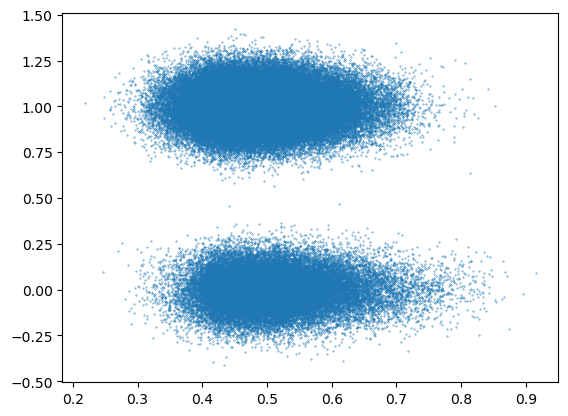

In [317]:
#plot 
noise = np.random.normal(0, 0.1, len(yTest))
yTestNoise = yTest + noise
plt.scatter(model2.predict_proba(XTest_scaled)[:,0], yTestNoise, s=.1)

(array([   52.,  2079., 22302., 52337., 42264., 15740.,  4197.,   872.,
          171.,    13.]),
 array([0.21846534, 0.28816409, 0.35786284, 0.42756159, 0.49726034,
        0.56695909, 0.63665784, 0.70635659, 0.77605534, 0.84575409,
        0.91545284]),
 <BarContainer object of 10 artists>)

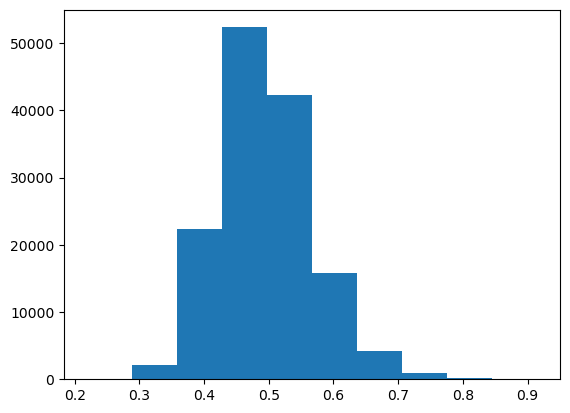

In [311]:
plt.hist(model2.predict_proba(XTest_scaled)[:,0])

# Scratch

In [113]:
import numpy as np
resp_time_lst = [d['resp_time'] / 1000 / 60 / 60 / 24 for d in reviews_with_responses]
np.quantile(resp_time_lst, [0.25, 0.5, 0.75])

array([0.46475142, 1.77545962, 7.78040038])

In [59]:
#resp_time_lst

In [22]:
bizs[0]

{'name': 'Montour WMA - Idaho Fish and Game',
 'address': 'Montour WMA - Idaho Fish and Game, Montour Rd, Emmett, ID 83617',
 'gmap_id': '0x54af0dfadab474e1:0x3ae5c949132941d8',
 'description': None,
 'latitude': 43.9295808,
 'longitude': -116.3333273,
 'category': ['Hunting area'],
 'avg_rating': 4.4,
 'num_of_reviews': 17,
 'price': None,
 'hours': None,
 'MISC': {'Accessibility': ['Wheelchair accessible parking lot']},
 'state': None,
 'relative_results': ['0x54af0df970009eab:0x998e663a1d2ea45',
  '0x54af0e08fb885aed:0xf626feadb2775442',
  '0x54afa0ce7af7268b:0x4b98fe1767238dc4',
  '0x54afc0324c4ca65b:0x808e759ecacfab1c',
  '0x54afb8ee4d09b825:0x50112376cec8c0ff'],
 'url': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x54af0dfadab474e1:0x3ae5c949132941d8?authuser=-1&hl=en&gl=us'}

In [31]:
reviews[5]

{'user_id': '108480743392575424354',
 'name': 'Dan Shadix',
 'time': 1525705287828,
 'rating': 5,
 'text': 'Love this float on paddle boards.  Nice flat water and fairly slow.',
 'pics': None,
 'resp': None,
 'gmap_id': '0x54af0dfadab474e1:0x3ae5c949132941d8'}

In [47]:
business_reviews = defaultdict(lambda: None)
for r in reviews:
    if r['resp'] and 'time' in r['resp']:
        business_reviews[r['gmap_id']] = r['resp']['time'] - r['time']

In [51]:
uniq_vals, counts = np.unique([r['gmap_id'] for r in reviews], return_counts=True)
len(uniq_vals[counts > 1])

31616

In [52]:
len(reviews)

3892636

In [53]:
31616/3892636*100

0.8122002673766568

In [ ]:
def feature(millisec):
    previousHours = []
    #### time of year feature
    for i in [24,24*7,24*7*365]:
        previousHour = hour - i
        previousHourExists = previousHour in hourly
        if previousHourExists:
            previousHours += [hourly[previousHour]]
        else:
            previousHours += [0]
    return previousHours